### set seed so that the model outputs are reproducible
After the kernel is restarted the same results are created.

In [22]:
import keras
import tensorflow as tf
from tensorflow.keras import initializers
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(0)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

## Load the data

In [23]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from scipy.stats import nbinom, poisson
from time import sleep
from tqdm import tqdm
import warnings


def check_Actuals(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        return False
    else:
        return True

# check if the last month of a country in the feature dataset is 3 months before the first month that has to be predicted
def check_last_featureMonth(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        raise ValueError('country does not have actuals')


    # last month of the feature dataset
    last_feature_month = country_feature_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[-1]

    # first month of the actual dataset
    first_actual_month = country_actual_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[0]

    # if the last month of the feature dataset in the country does not match the first of the actuals return false
    if (first_actual_month - 3) != last_feature_month:
        return False
    else:
        return True


# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])

### Drop features that contain missing values

In [24]:
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


data = features_df_list[-1]['data']
if 'gleditsch_ward' in data.columns:
    data = data.drop(columns='gleditsch_ward') # column not necessary

## Features without missing values
columns_without_missing_values = data.columns[data.notna().all()]

for i in range(len(features_df_list)):
    data_set = features_df_list[i]['data']
    features_df_list[i]['data'] = data_set[columns_without_missing_values]

all_features = features_df_list[-1]['data'].columns

### Group data by country_id

In [25]:
country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

## Länder aussortieren
die nicht gefordert sind und
*  die keine actuals haben
*  die zu wenig Beobachtungen haben

In [26]:
relative_path_countrylist = os.path.join('..', 'data', 'country_list.csv')
path_countrylist = os.path.join(current_dir, relative_path_countrylist)

# CSV-Datei einlesen und als Pandas-Datensatz speichern
countryList_prediction = pd.read_csv(path_countrylist)
country_list_views = countryList_prediction.loc[:,'country_id'].values.tolist() 

month_list = []
countries_to_remove = []
for country_id in country_list:

    if country_id in country_list_views:
        feature_data = country_feature_group_list[0].get_group(country_id)

        # numbers of months from the feature dataset
        month_list_feature_data_original = feature_data.index.get_level_values('month_id').tolist()
        number_months_feature_data = len(month_list_feature_data_original) 

        if check_Actuals(country_id, 0):
            if not check_last_featureMonth(country_id, 0): 
                month_list.append([str(country_id) +' last month missing'])
            else:
                month_list.append([number_months_feature_data, country_id])
        else:
            month_list.append(str(country_id) + ' no actuals')
    else:
        countries_to_remove.append(country_id)

country_list = list(set(country_list) - set(countries_to_remove))
month_list.sort()

## Feed Forward Neural Network
Goal is to estimate the empirical distribution of the fatalities per month.
### Definition of the CRPS loss function and the Feed forward Neural Network subclass

In [27]:
# functions to set the number and partition of the neurons
def number_neurons_allLayers(inputNeurons, outputNeurons):
    return np.round(np.mean([inputNeurons, outputNeurons]))

def split_neurons_3hiddenlayer(numberNeurons):

    neuronsHiddenLayer1 = np.round(numberNeurons * 0.5) 
    neuronsHiddenLayer2 = np.round(numberNeurons * 0.3)
    neuronsHiddenLayer3 = numberNeurons - neuronsHiddenLayer1 - neuronsHiddenLayer2

    return int(neuronsHiddenLayer1), int(neuronsHiddenLayer2), int(neuronsHiddenLayer3)

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Input, Dense, Lambda, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

# crps loss function 
def crps(y_true, S):
    """
    Computes continuous ranked probability score:

    Parameters
    ----------
    y_true : tf tensor of shape (BATCH_SIZE, 1)
        True values.
    S : tf tensor of shape (BATCH_SIZE, N_SAMPLES)
        Predictive samples.

    Returns
    -------
    tf tensor of shape (BATCH_SIZE,)
        Scores.

    """
    beta=1
    n_samples = S.shape[-1]

    def expected_dist(diff, beta):
        return K.sum(K.pow(K.sqrt(K.square(diff)+K.epsilon()), beta),axis=-1) #axis = -1: last dimension <=> N_SAMPLES
    es_1 = expected_dist(y_true - S, beta)
    es_2 = 0
    for i in range(n_samples):
        es_2 = es_2 + expected_dist(K.expand_dims(S[:,i]) - S, beta)
    return es_1/n_samples - es_2/(2*n_samples**2)


class CRPSLoss(Loss):
    def call(self, y_true, S):
        return crps(y_true, S)

# Define custom ReLU activation function
class ReLUTransform(Layer):
    def call(self, inputs):
        return tf.nn.relu(inputs)

# Define the Feed Forward Neural Network subclass
class FeedForwardNN(tf.keras.Model):
    def __init__(self, input_shape, name="FeedFwdNN"):
        super(FeedForwardNN, self).__init__(name=name)
        
        neurons_input = input_shape[-1]
        neurons_output = 200
        neurons_hidden_layer = number_neurons_allLayers(neurons_input,neurons_output)
        neuronsL1, neuronsL2, neuronsL3 = split_neurons_3hiddenlayer(neurons_hidden_layer)


        self.hidden_layer1 = Dense(neuronsL1, activation='relu')
        self.dropout = Dropout(0.3)
        self.hidden_layer2 = Dense(neuronsL2, activation='relu')
        self.hidden_layer3 = Dense(neuronsL3, activation='relu')
        self.untransformed_output = Dense(neurons_output)
        self.final_output = Lambda(ReLUTransform())

        self.model = self.build(input_shape)
        
    def call(self, inputs):
        x = self.hidden_layer1(inputs)
        #x = self.dropout(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        x = self.untransformed_output(x)
        y = self.final_output(x)
        return y

# Definiere den EarlyStopping-Callback
patience = 4
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


### Data preparation for the Neural Net

In [115]:
import math
from sklearn import preprocessing
## function used to calculate w_max, number of rolling windows etc.
# length of a whole window (containing w input months and 12 acutal months)
def rollingWindowLength(w):
    return w + 2 + 12

def number_valid_months(numberMonths_available, w, relative_validation_size):

    number_train_valid_months = numberMonths_available - w
    number_valid_months = math.floor(number_train_valid_months * relative_validation_size)

    return number_valid_months

# number of months available for training (after removing the validation and test months)
def number_train_months(numberMonths_available, w, relative_validation_size):

    valid_months = number_valid_months(numberMonths_available, w, relative_validation_size)

    #  all months feature data   -  validate set    -   test set input
    return numberMonths_available - valid_months - w


def number_rolling_windows(numberMonths_available, w):
    return max(0,numberMonths_available - rollingWindowLength(w) + 1)



def find_max_W(numberMonths_available, w_min, w_max, relative_validation_size):

    # with "w_min" and the "relative_validation_size" there has to be at least one validation window
    number_valid_months_wmin = number_valid_months(numberMonths_available, w_min, relative_validation_size)

    if number_rolling_windows(number_valid_months_wmin, w_min) == 0:
        raise ValueError('not enough months for one validation window with w_min = ' + str(w_min))

    # with "w_min" and the "relative_validation_size" there has to be at least one train window
    number_train_months_wmin = number_train_months(numberMonths_available, w_min, relative_validation_size)

    if number_rolling_windows(number_train_months_wmin, w_min) == 0:
        raise ValueError('not enough months for one training window with w_min = ' + str(w_min))

    # find the maximal w
    max_W = w_max
    number_valid_months_wmax = number_valid_months(numberMonths_available, max_W, relative_validation_size)
    number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months_wmax, max_W)

    number_train_months_wmax = number_train_months(numberMonths_available, max_W, relative_validation_size)
    number_train_rollwindows_wmax = number_rolling_windows(number_train_months_wmax, max_W)

    # calculate w_max so that the number of rolling windows for the validation set is >= 1
    # and that
    # the number of rolling windows for the train set is >= 1
    while (number_valid_rollwindows_wmax == 0 or number_train_rollwindows_wmax == 0) and max_W > w_min:
        max_W -= 1
        number_valid_months_wmax = number_valid_months(numberMonths_available, max_W, relative_validation_size)
        number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months_wmax, max_W)

        number_train_months_wmax = number_train_months(numberMonths_available, max_W, relative_validation_size)
        number_train_rollwindows_wmax = number_rolling_windows(number_train_months_wmax, max_W)

    return max_W

## conflict trap
# drops all months before a starting conflict
# defintion of a beginning conflict: fatalities(monthX) > 0 with mean(fatalities(window_size number months starting with monthX)) > threshold
# (average fatalities per month in the starting half year are greater than the threshold)
# iterates trough the dataset beginning with the first entry
def drop_before_conflict_trap(data, threshold, window_size, minimal_data_size):
    index_ged_sb = data.columns.get_loc('ged_sb')

    start_index = 0
    while start_index < len(data.iloc[:,index_ged_sb]) - window_size + 1:
        window = data.iloc[start_index:start_index + window_size, index_ged_sb].to_list()
        
        if window[0] > 0 and sum(window) / window_size >= threshold:
            break
        else:
            start_index += 1


    if len(data) >= minimal_data_size:
        # if there is no conflict trap do nothing
        if start_index == len(data.iloc[:,index_ged_sb]) - window_size + 1:
            return data
        # if the truncation would result in a too small dataset prevent this
        elif len(data.iloc[start_index:, :]) < minimal_data_size:
            return data.iloc[-minimal_data_size:, :]
        # drop every entry before the conflict trap 
        else:
            return data.iloc[start_index:, :]
    else:
        return data
    

def TrainValid_ArrayXY_split(w, month_list, data_feature, s):
    X = []
    Y = []

    train_months = len(month_list)

    number_rolling_windows_train = number_rolling_windows(train_months, w)

    for i in range(0, number_rolling_windows_train):
        starting_month_features = month_list[i]

        index_ending_month_features = i + w - 1
        ending_month_features = month_list[index_ending_month_features]

        starting_month_unrActuals = month_list[index_ending_month_features + 3]
        ending_month_unrActuals = month_list[index_ending_month_features + 14]

        window_features = data_feature.loc[slice(starting_month_features, ending_month_features), :] # excluding "unreal" actuals
        window_actuals = data_feature.loc[slice(starting_month_unrActuals, ending_month_unrActuals), 'ged_sb'].iloc[s - 3] # "unreal" actuals


        normalized_window_features = preprocessing.normalize(window_features)
        window_features_array = np.array([normalized_window_features.flatten()])[0]

        window_actual_array = np.array([window_actuals])

        X.append(window_features_array)
        Y.append(window_actual_array)

    X = np.array(X)
    Y = np.array(Y)

    return X,Y

def Test_ArrayXY_split(month_list, data_feature, data_actual, s):
    X = []
    Y = []

    starting_month_test = month_list[0]
    ending_month_test = month_list[-1]

    window_features_test = data_feature.loc[slice(starting_month_test, ending_month_test), :] # all w features to predict the fatalities
    window_actuals_test = data_actual.iloc[s - 3].values # real actuals

    normalized_window_features_test = preprocessing.normalize(window_features_test)
    window_features_array_test = np.array([normalized_window_features_test.flatten()])[0]

    window_actual_array_test = window_actuals_test

    X.append(window_features_array_test)
    Y.append(window_actual_array_test)

    X = np.array(X)
    Y = np.array(Y)

    return X,Y

In [149]:
def rollingWindowLength(w):
    return w + 2 + 12

### non need of w, due to no test set in the hyperparam validation split
def number_valid_monthsRollWindow(numberMonths_available, relative_validation_size):

    number_valid_months = math.floor(numberMonths_available * relative_validation_size)

    return number_valid_months

# number of months available for training (after removing the validation and test months)
def number_train_monthsRollWindow(numberMonths_available, relative_validation_size):

    valid_months = number_valid_monthsRollWindow(numberMonths_available, relative_validation_size)

    #  all months feature data   -  validate set
    return numberMonths_available - valid_months


def number_rolling_windows(numberMonths_available, w):
    return max(0,numberMonths_available - rollingWindowLength(w) + 1)


# no -w because of no test set
def find_max_WRollWindow(numberMonths_available, w_min, w_max, relative_validation_size):

    # with "w_min" and the "relative_validation_size" there has to be at least one validation window
    number_valid_months = number_valid_monthsRollWindow(numberMonths_available, relative_validation_size)

    if number_rolling_windows(number_valid_months, w_min) == 0:
        raise ValueError('not enough months for one validation window with w_min = ' + str(w_min))

    # with "w_min" and the "relative_validation_size" there has to be at least one train window
    number_train_months = number_train_monthsRollWindow(numberMonths_available, relative_validation_size)

    if number_rolling_windows(number_train_months, w_min) == 0:
        raise ValueError('not enough months for one training window with w_min = ' + str(w_min))

    # find the maximal w
    max_W = w_max
    number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months, max_W)

    number_train_rollwindows_wmax = number_rolling_windows(number_train_months, max_W)

    # calculate w_max so that the number of rolling windows for the validation set is >= 1
    # and that
    # the number of rolling windows for the train set is >= 1
    while (number_valid_rollwindows_wmax == 0 or number_train_rollwindows_wmax == 0) and max_W > w_min:
        max_W -= 1
        number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months, max_W)

        number_train_rollwindows_wmax = number_rolling_windows(number_train_months, max_W)

    return max_W




def month_lists_trainValid_RollWindow(w_min, w_max, rel_validation_size, k, k_max, month_list_feature_data):

    # make sure that the lateron used test dataset is not contained in the train/validation process ?!?
    month_list_feature_data_withoutW = month_list_feature_data[:-w_max]

    starting_month = k - 1
    ending_month = k_max - starting_month - 1

    if ending_month == 0:
        month_list_rollwindow_k = month_list_feature_data_withoutW[starting_month:]
    else: 
        month_list_rollwindow_k = month_list_feature_data_withoutW[starting_month:-ending_month]
    

    # numbers of months from the feature dataset
    first_month = min(month_list_rollwindow_k)
    last_month = max(month_list_rollwindow_k)
    number_months_rollwindow_k = len(month_list_rollwindow_k)
    
    # find w_max (as mentioned above, if there are not enoug months, the w_max has to be < w_max)
    w_max_local = find_max_WRollWindow(number_months_rollwindow_k, w_min, w_max, rel_validation_size)

    w = w_max_local
    print('Wmax = ' + str(w_max) + ' w = ' + str(w))

    # length of the maximum rolling window and the used "unreal" acutals starting 3 months after the last used month
    n_train_months = number_train_monthsRollWindow(number_months_rollwindow_k, rel_validation_size)
    n_valid_months = number_valid_monthsRollWindow(number_months_rollwindow_k, rel_validation_size)

    print('rolling windows train: ' + str(number_rolling_windows(n_train_months, w)))
    print('rolling windows validate: ' + str(number_rolling_windows(n_valid_months, w)))

    month_list_train = month_list_rollwindow_k[0:n_train_months]
    month_list_valid = month_list_rollwindow_k[n_train_months:(n_train_months+n_valid_months)]

    month_list_test = month_list_feature_data[-w:]

    return month_list_train, month_list_valid, month_list_test





#--------------------


""" ## training dataset------
X_train, Y_train = TrainValid_ArrayXY_split(n_train_months, w, month_list_train, feature_data, s)

## validation dataset--------
X_validate, Y_validate = TrainValid_ArrayXY_split(n_valid_months, w, month_list_valid, feature_data, s) """





' ## training dataset------\nX_train, Y_train = TrainValid_ArrayXY_split(n_train_months, w, month_list_train, feature_data, s)\n\n## validation dataset--------\nX_validate, Y_validate = TrainValid_ArrayXY_split(n_valid_months, w, month_list_valid, feature_data, s) '

In [151]:
country = 220 #220  245

# check if the last month of the country in the feature dataset is 3 months before the first month that has to be predicted
if not check_last_featureMonth(country, dataset_index):
    raise ValueError('last month is not contained in the data')

### load and prepare datasets
feature_data = country_feature_group_list[dataset_index].get_group(country)

# only FEATURE SUBSET
feature_data = feature_data.loc[:,feature_subset_dict[feature_subset]]

## Drop features with NEAR ZERO VARIANCE (but dont drop 'ged_sb' -> needed for conflict trap detection)
columns_to_keep = [col for col in feature_data.columns if (col == 'ged_sb') or (feature_data[col].var() >= var_threshold)]
feature_data = feature_data[columns_to_keep]

actual_data = country_actual_group_list[dataset_index].get_group(country)

## remove months before the CONDFLICT TRAP (regime change)
# if the average number of fatalities per month in 6 months is above 'mean_fatlities_per_month_threshold' and the fatalities of the starting month are > 0 
# the conflict trap starts and all obsservations before that month are dropped
# 76 is the minimal length of the dataframe (refers to the minimal size of the data for all countries -> country_id 246 len = 76) 
feature_data = drop_before_conflict_trap(feature_data, mean_fatlities_per_month_threshold, 6, 76)




month_liste = month_list_feature_data
w_min = 2
w_max = 6
rel_validation_size = 0.5
k_max = 5
s = 14
w = w_max

XY_train_list_ktimes = []
XY_validate_list_ktimes = []

print('Starting month: ' + str(month_liste[0]))
print('Ending month: ' + str(month_liste[-1]))

for k in range(1,k_max+1):
    month_list_train, month_list_valid, month_list_test = month_lists_trainValid_RollWindow(w_min, w_max, rel_validation_size, k, k_max, month_liste)

    print(month_list_train)
    print(month_list_valid)
    print(month_list_test)

    ## training dataset------
    X_train, Y_train = TrainValid_ArrayXY_split(w, month_list_train, feature_data, s)
    XY_train_list_ktimes.append({'X_train': X_train, 'Y_train': Y_train})

    ## validation dataset--------
    X_validate, Y_validate = TrainValid_ArrayXY_split(w, month_list_valid, feature_data, s)
    XY_validate_list_ktimes.append({'X_validate': X_validate, 'Y_validate': Y_validate})

    



Starting month: 379
Ending month: 490
Wmax = 6 w = 6
rolling windows train: 32
rolling windows validate: 32
[379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429]
[430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480]
[485, 486, 487, 488, 489, 490]
Wmax = 6 w = 6
rolling windows train: 32
rolling windows validate: 32
[380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430]
[431, 432, 433, 434, 43

In [133]:
len(XY_train_list_ktimes[0]['X_train'])

44

### Feature subsets

In [31]:
## different feature selection from views
# 59 features that map the conflict history of a country
conflict_history = [
    'ged_sb', 'decay_ged_sb_5', 'decay_ged_os_5',
    'splag_1_decay_ged_sb_5', 'wdi_sp_pop_totl', 'ln_ged_sb_tlag_1',
    'ln_ged_sb_tlag_2', 'ln_ged_sb_tlag_3', 'ln_ged_sb_tlag_4',
    'ln_ged_sb_tlag_5', 'ln_ged_sb_tlag_6', 'ln_ged_sb_tsum_24',
    'decay_ged_sb_100', 'decay_ged_sb_500', 'decay_ged_os_100',
    'decay_ged_ns_5', 'decay_ged_ns_100', 'ln_ged_ns', 'ln_ged_os',
    'ln_acled_sb', 'ln_acled_sb_count', 'ln_acled_os',
    'ln_ged_os_tlag_1', 'decay_acled_sb_5', 'decay_acled_os_5',
    'decay_acled_ns_5', 'splag_1_decay_ged_os_5',
    'splag_1_decay_ged_ns_5'
]
# 59 features that are drawn from the Varieties of Democracy project
vdem = [
    'ged_sb', 'decay_ged_sb_5', 'decay_ged_os_5',
    'splag_1_decay_ged_sb_5', 'wdi_sp_pop_totl', 'vdem_v2x_delibdem',
    'vdem_v2x_egaldem', 'vdem_v2x_libdem', 'vdem_v2x_libdem_48',
    'vdem_v2x_partip', 'vdem_v2x_accountability',
    'vdem_v2x_civlib', 'vdem_v2x_clphy', 'vdem_v2x_cspart',
    'vdem_v2x_divparctrl', 'vdem_v2x_edcomp_thick', 'vdem_v2x_egal',
    'vdem_v2x_execorr', 'vdem_v2x_frassoc_thick', 'vdem_v2x_gencs',
    'vdem_v2x_gender', 'vdem_v2x_genpp', 'vdem_v2x_horacc',
    'vdem_v2x_neopat', 'vdem_v2x_pubcorr', 'vdem_v2x_rule',
    'vdem_v2x_veracc', 'vdem_v2x_freexp', 'vdem_v2xcl_acjst', 
    'vdem_v2xcl_dmove', 'vdem_v2xcl_prpty', 'vdem_v2xcl_rol', 
    'vdem_v2xcl_slave', 'vdem_v2xdl_delib', 'vdem_v2xeg_eqdr',
    'vdem_v2xeg_eqprotec', 'vdem_v2xel_frefair', 'vdem_v2xel_regelec',
    'vdem_v2xme_altinf', 'vdem_v2xnp_client', 'vdem_v2xnp_regcorr',
    'vdem_v2xpe_exlecon', 'vdem_v2xpe_exlpol', 'vdem_v2xpe_exlgeo',
    'vdem_v2xpe_exlgender', 'vdem_v2xpe_exlsocgr', 'vdem_v2xps_party',
    'vdem_v2xcs_ccsi', 'vdem_v2xnp_pres', 'vdem_v2xeg_eqaccess',
    'vdem_v2x_diagacc', 'vdem_v2clrgunev', 'splag_vdem_v2x_libdem',
    'splag_vdem_v2xcl_dmove', 'splag_vdem_v2x_accountability',
    'splag_vdem_v2xpe_exlsocgr', 'splag_vdem_v2xcl_rol', 'wdi_sm_pop_netm',
    'wdi_sp_dyn_imrt_in'
]

# 30 features that are drawn from the WDI as well as some conflict history indicators
wdi = [
    'ged_sb', 'decay_ged_sb_5', 'decay_ged_os_5',
    'splag_1_decay_ged_sb_5', 'wdi_sp_pop_totl', 'wdi_ag_lnd_frst_k2',
    'wdi_dt_oda_odat_pc_zs', 'wdi_ms_mil_xpnd_gd_zs', 'wdi_ms_mil_xpnd_zs',
    'wdi_nv_agr_totl_kd', 'wdi_nv_agr_totl_kn', 'wdi_ny_gdp_pcap_kd',
    'wdi_sp_dyn_le00_in', 'wdi_se_prm_nenr', 'wdi_sh_sta_maln_zs', 
    'wdi_sh_sta_stnt_zs', 'wdi_sl_tlf_totl_fe_zs', 'wdi_sm_pop_refg_or', 
    'wdi_sm_pop_netm', 'wdi_sm_pop_totl_zs', 'wdi_sp_dyn_imrt_in', 
    'wdi_sh_dyn_mort_fe', 'wdi_sp_pop_1564_fe_zs', 'wdi_sp_pop_65up_fe_zs',
    'wdi_sp_pop_grow', 'wdi_sp_urb_totl_in_zs',
    'splag_wdi_sl_tlf_totl_fe_zs', 'splag_wdi_sm_pop_refg_or',
    'splag_wdi_sm_pop_netm', 'splag_wdi_ag_lnd_frst_k2'
]

feature_subset_dict = {'conflict_history':conflict_history,
                       'vdem':vdem,
                       'wdi':wdi,
                       'all':all_features}

In [32]:
### prediction task old
prediction_year = '2021'
dataset_index = actual_years.index(prediction_year)
s = 3 # month to predict element out of [3,14]

### set hyperparameters for the prediction task
## dataset (split) hyperparams
rel_validation_size = 0.4 # percentual size of the validation set
var_threshold = 0.05 # variance threshold for dropping columns
mean_fatlities_per_month_threshold = 5 # threshold for the average number of fatalities per month (conflict trap detection)

w_max = 6 # the maximal w (months to estimate the fatalities from) is set to e.g. 3 years (36 months)
# BUT: If w_max=36 leads to a number of rolling windows < 1 in the validation dataset,
# w_max is set to the maximal w, so that the number of rolling windows is >= 1
# => this step is done below in the section for each country

w_min = 2 # to calculate the w_max the w_min has to be set as well

feature_subset = 'wdi' # 'conflict_history', 'vdem', 'wdi', 'all',


## country 223
country = 220 #220  245

# check if the last month of the country in the feature dataset is 3 months before the first month that has to be predicted
if not check_last_featureMonth(country, dataset_index):
    raise ValueError('last month is not contained in the data')

### load and prepare datasets
feature_data = country_feature_group_list[dataset_index].get_group(country)

# only FEATURE SUBSET
feature_data = feature_data.loc[:,feature_subset_dict[feature_subset]]

## Drop features with NEAR ZERO VARIANCE (but dont drop 'ged_sb' -> needed for conflict trap detection)
columns_to_keep = [col for col in feature_data.columns if (col == 'ged_sb') or (feature_data[col].var() >= var_threshold)]
feature_data = feature_data[columns_to_keep]

actual_data = country_actual_group_list[dataset_index].get_group(country)

## remove months before the CONDFLICT TRAP (regime change)
# if the average number of fatalities per month in 6 months is above 'mean_fatlities_per_month_threshold' and the fatalities of the starting month are > 0 
# the conflict trap starts and all obsservations before that month are dropped
# 76 is the minimal length of the dataframe (refers to the minimal size of the data for all countries -> country_id 246 len = 76) 
feature_data = drop_before_conflict_trap(feature_data, mean_fatlities_per_month_threshold, 6, 76)


# numbers of months from the feature dataset
month_list_feature_data = feature_data.index.get_level_values('month_id').tolist()
first_month = min(month_list_feature_data)
last_month = max(month_list_feature_data)
number_months_feature_data = len(month_list_feature_data) # number of months in the feature dataset

# find w_max (as mentioned above, if there are not enoug months, the w_max has to be < 36)
w_max_local = find_max_W(number_months_feature_data, w_min, w_max, rel_validation_size)

w = w_max_local

### split data in train-, validation- and test-dataset
""" The data sizes are calculated in a way, that missing months are no problem. Additionaly due to the fact, that the data is sorted
    regarding months, this step can be skipped. """

## train-valid-test------------------
# length of the maximum rolling window and the used "unreal" acutals starting 3 months after the last used month
n_train_months = number_train_months(number_months_feature_data, w, rel_validation_size)
n_valid_months = number_valid_months(number_months_feature_data, w, rel_validation_size)
n_test_months = w

month_list_train = month_list_feature_data[0:n_train_months]
month_list_valid = month_list_feature_data[n_train_months:(n_train_months+n_valid_months)]
month_list_test = month_list_feature_data[number_months_feature_data-n_test_months:]
#--------------------


## training dataset------
X_train, Y_train = TrainValid_ArrayXY_split(w, month_list_train, feature_data, s)

## validation dataset--------
X_validate, Y_validate = TrainValid_ArrayXY_split(w, month_list_valid, feature_data, s)

## test dataset-------
X_test, Y_test = Test_ArrayXY_split(month_list_test, feature_data, actual_data, s)


print('(first, last) train month: (' + str(month_list_train[0])+','+str(month_list_train[-1])+')')
print('(first, last) validate month: (' + str(month_list_valid[0])+','+str(month_list_valid[-1])+')')
print('(first, last) test month: (' + str(month_list_test[0])+','+str(month_list_test[-1])+')')
print('train + valid + test = ' + str(n_train_months + n_valid_months +n_test_months) + ' != ' + str(number_months_feature_data))


print('')
print('# rolling w train: ' + str(number_rolling_windows(n_train_months, w)) + '      # rolling w validate: ' + str(number_rolling_windows(n_valid_months, w)))
print('w = ' + str(w) + ' w_max = ' + str(w_max))

(first, last) train month: (379,442)
(first, last) validate month: (443,484)
(first, last) test month: (485,490)
train + valid + test = 112 != 112

# rolling w train: 45      # rolling w validate: 23
w = 6 w_max = 6


# Einschub: Analyse der unterschiedlichen Ländern mit Conflict trap

### Countries separated by fatalities

In [33]:
zero_fatalities_country_list = []
countries_with_high_percentage_list = []
someNonzero_fatalities_country_list = []

for country_id in country_list:
    feature_data = country_feature_group_list[0].get_group(country_id)

    # Berechnen des Prozentsatzes der Werte größer als 0 in der Spalte 'ged_sb'
    positive_percentage = (feature_data['ged_sb'] > 0).mean() * 100

    if (feature_data['ged_sb'] == 0).all():
        zero_fatalities_country_list.append(country_id)
    elif positive_percentage >= 60:
        countries_with_high_percentage_list.append(country_id)
    else:
        someNonzero_fatalities_country_list.append(country_id)

print('Countries with >= 60% months with fatalities: ' + str(countries_with_high_percentage_list))

Countries with >= 60% months with fatalities: [28, 60, 65, 67, 96, 121, 133, 136, 145, 149, 218, 223, 245, 246]


### Countries with conflict trap and the removed months

In [34]:
country_list_nonzerofatalities = countries_with_high_percentage_list + someNonzero_fatalities_country_list
country_list_nonzerofatalities.sort()
country_list_nonzerofatalities

for country_id in country_list_nonzerofatalities:
    feature_data = country_feature_group_list[0].get_group(country_id)

    trap_data = drop_before_conflict_trap(feature_data, 10, 6, 76)

    if len(trap_data) < len(feature_data):
        print('trap country_id: ' + str(country_id) + ' removed months: ' + str(len(feature_data)-len(trap_data)) + ' len trap_data = ' + str(len(trap_data)))

trap country_id: 4 removed months: 25 len trap_data = 309
trap country_id: 17 removed months: 48 len trap_data = 286
trap country_id: 24 removed months: 21 len trap_data = 313
trap country_id: 31 removed months: 1 len trap_data = 333
trap country_id: 41 removed months: 152 len trap_data = 182
trap country_id: 48 removed months: 128 len trap_data = 206
trap country_id: 49 removed months: 101 len trap_data = 233
trap country_id: 50 removed months: 5 len trap_data = 329
trap country_id: 52 removed months: 32 len trap_data = 302
trap country_id: 53 removed months: 14 len trap_data = 320
trap country_id: 55 removed months: 4 len trap_data = 330
trap country_id: 56 removed months: 67 len trap_data = 227
trap country_id: 57 removed months: 5 len trap_data = 289
trap country_id: 65 removed months: 21 len trap_data = 290
trap country_id: 67 removed months: 22 len trap_data = 312
trap country_id: 69 removed months: 258 len trap_data = 76
trap country_id: 70 removed months: 136 len trap_data = 19

In [35]:
max_fatalities = 0
country_id_max = 0

for country_id in country_list_nonzerofatalities:
    feature_data = country_feature_group_list[0].get_group(country_id)

    if feature_data.loc[:,'ged_sb'].max() > max_fatalities:
        max_fatalities = feature_data.loc[:,'ged_sb'].max()
        country_id_max = country_id

print('Country: ' + str(country_id_max) + ' fatalities = ' + str(max_fatalities))

Country: 57 fatalities = 48183.0


### View dataset of country with id

In [36]:
pd.options.display.max_rows = 1000


""" 
    - 1 keine todesfälle
    - 57 extrem selten todesfälle aber ein paar sind extrem hoch (maximum aller länder -> in einem Monat: 48183.0)
    - 235 krieg der aufgehört hat
    - 13 aktuell wenige todesfälle vor langer zeit mehr (krieg der aufgehört hat aber noch immer etwas schwelt)
    - 121 krieg der aufgehört hat aber wieder angefangen hat und dann wieder aufgehört hat
    - 223 konstant mittlere todesfälle, nur 1 von 334 monaten 0 
    - 220 ausgebrochener krieg mit sehr hohen todeszahlen und conflict trap
    """

data = country_feature_group_list[0].get_group(223)

#data = drop_before_conflict_trap(data, 30, 6, 76)

data.loc[:,'ged_sb'] == 0


month_id  country_id
121       223           False
122       223           False
123       223           False
124       223           False
125       223           False
126       223           False
127       223           False
128       223           False
129       223            True
130       223           False
131       223           False
132       223           False
133       223           False
134       223           False
135       223           False
136       223           False
137       223           False
138       223           False
139       223           False
140       223           False
141       223           False
142       223           False
143       223           False
144       223           False
145       223           False
146       223           False
147       223           False
148       223           False
149       223           False
150       223           False
151       223           False
152       223           False
153       223      

# To Do

In [37]:
#feature_data.drop(rows=[0:20])
""" 


- für jedes der drei bis vier verschiedenen Typen an Ländern (zeros, konstant niedrige Todeszahlen, hohe Todeszahlen)
  ein/mehrere entsprechende Kandidaten finden und daran alle Parameter tunen 
  -> conflict trap parameter (insbesondere auch generelle größe datensatz), 
  w_max, neuronales Netz layer, batchSize, learningRate, epoch !! das dann als ergebnis für alle nehmen
  -> das alles auch mit plots belegen

seed setzen -> ergebnisse reproduzierbar? wenn nicht möglich nn speichern!  DONE



kleinerer datensatz alle nur 76 -> zeitreiheneigenschaft insgesamt weniger daten? kleineres w generell besser?

-> exemplarische Länder raussuchen """

""" bis nächste woche implementieren

danach schon paper anfangen

titel ba """


' bis nächste woche implementieren\n\ndanach schon paper anfangen\n\ntitel ba '

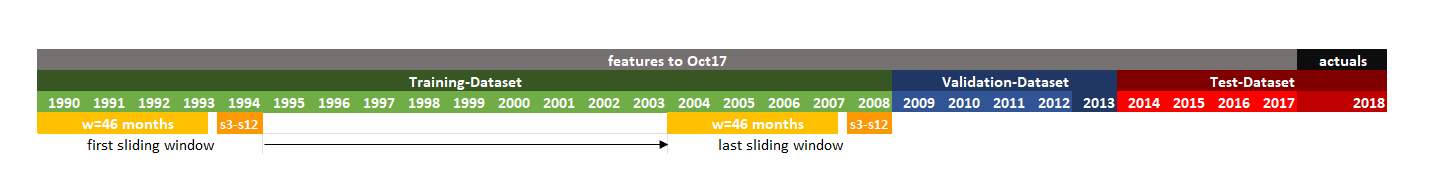

### Estimation and Prediction

In [38]:
## neural net hyperparams
batchSize = 1
epochSize = 100
learningRate = 0.1

# Define inputs with predefined shape
input_shape = (len(X_train[0]),)
inputs = Input(shape=input_shape)
#print(inputs.shape)

# Print model summary
#model.summary()


# Create an instance of the FeedForwardNN model
model = FeedForwardNN(input_shape=inputs.shape, name='FFwdNN_s3')

# Compile the model
model.compile(optimizer=Adam(learning_rate=learningRate), loss=CRPSLoss())

history = model.fit(X_train, Y_train, 
                    batch_size=batchSize, epochs=epochSize,
                    validation_data=(X_validate, Y_validate),
                    callbacks=[early_stopping], #early_stopping
                    verbose=1, shuffle=False)


print('')
print('')

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test, batch_size=batchSize)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate prediction")
prediction = model.predict(X_test)
print("predictions shape:", prediction.shape)
empirical_distribution = np.round(np.sort(prediction[0])).astype(int)


Epoch 1/100
45/45 [==============================] - 27s 105ms/step - loss: 2370.0359 - val_loss: 822.6118
Epoch 2/100
45/45 [==============================] - 0s 8ms/step - loss: 2543.6760 - val_loss: 692.7082
Epoch 3/100
45/45 [==============================] - 0s 9ms/step - loss: 2493.5867 - val_loss: 841.6634
Epoch 4/100
45/45 [==============================] - 0s 10ms/step - loss: 2554.8647 - val_loss: 632.9290
Epoch 5/100
45/45 [==============================] - 0s 10ms/step - loss: 2334.8044 - val_loss: 818.5798
Epoch 6/100
45/45 [==============================] - 0s 10ms/step - loss: 2272.5730 - val_loss: 721.6856
Epoch 7/100
45/45 [==============================] - 0s 11ms/step - loss: 2182.1343 - val_loss: 798.0656
Epoch 8/100
45/45 [==============================] - 0s 11ms/step - loss: 2128.7522 - val_loss: 832.0733


Evaluate on test data
1/1 [==============================] - 0s 54ms/step - loss: 582.4789
Generate prediction
1/1 [==============================] - 0s 117ms

In [39]:
print('Parameters data prep: ' + ' \\'+'\\' + 'wMax='+ str(w_max) + ' validationSize='+str(rel_validation_size) + ' conflictTrapThresh=' + str(mean_fatlities_per_month_threshold) + ' features='+feature_subset+ ' \\'+'\\')
print('Parameters NN: ' + ' \\'+'\\' + 'earlyStoppingPatience=' + str(patience) + ' learningRate='+str(learningRate)+' numberHiddenLayers=2 numberNeurons=neurons_hidden_layer validationSize='+str(rel_validation_size))

Parameters data prep:  \\wMax=6 validationSize=0.4 conflictTrapThresh=5 features=wdi \\
Parameters NN:  \\earlyStoppingPatience=4 learningRate=0.1 numberHiddenLayers=2 numberNeurons=neurons_hidden_layer validationSize=0.4


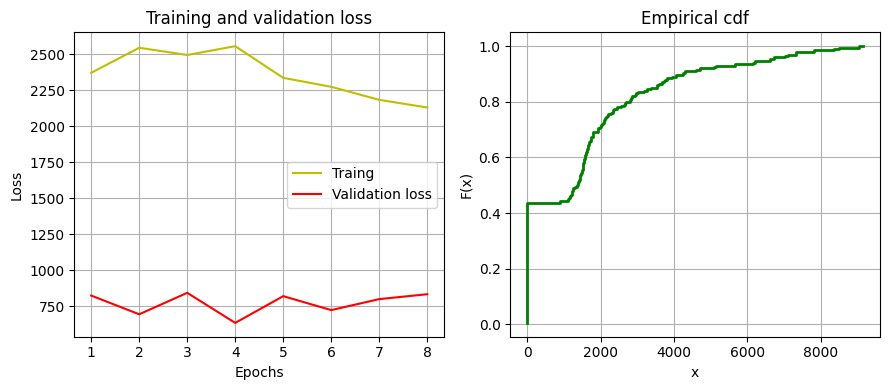

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def empirical_cdf(data):
    n = len(data)
    ecdf_values = np.arange(1, n + 1) / n
    return ecdf_values

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Berechne die empirische CDF
ecdf = empirical_cdf(empirical_distribution)

# Erstelle eine Figur mit 1 Zeile und 2 Spalten für die beiden Plots nebeneinander und kleiner
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].plot(epochs, loss, 'y', label='Traing')
axes[0].plot(epochs, val_loss, 'r', label='Validation loss')
axes[0].set_title('Training and validation loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plotte die empirische CDF im zweiten Subplot
axes[1].step(empirical_distribution, ecdf, label='Empirical Density Function', color='green', linewidth=2)
axes[1].set_xlabel('x')
axes[1].set_ylabel('F(x)')
axes[1].set_title('Empirical cdf')
axes[1].grid(True)

plt.tight_layout()  # Optimiere den Abstand zwischen den Subplots
plt.show()


In [41]:
y_true = Y_test[0][0]
crps_check = pscore(empirical_distribution,y_true).compute()[0]
print('CRPS = ' + str(crps_check))

CRPS = 582.451675


In [42]:
empirical_distribution

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  883,  903,
       1118, 1134, 1176, 1195, 1216, 1217, 1223, 1245, 1263, 1297, 1354,
       1376, 1378, 1411, 1412, 1439, 1451, 1454, 1461, 1480, 1492, 1497,
       1511, 1513, 1525, 1528, 1535, 1546, 1550, 1554, 1575, 1576, 1583,
       1594, 1610, 1620, 1640, 1664, 1666, 1670, 1680, 1681, 1719, 1739,
       1752, 1753, 1793, 1796, 1796, 1920, 1943, 1944, 1986, 2016, 2039,
       2062, 2087, 2100, 2118, 2137, 2180, 2200, 22

In [43]:
""" größere emp. distribution  hat kaum einen Einfluss, wird nur genauer abgebildet

    mehr neuronen in den Hidden layers führen zu einem heavier tail (mehr extremwerte) -> schlechtere performance

    zwei hidden layer neigen bei zu vielen neuronen zu overfitting, allerdings liefern zwei hidden layer mit weniger
    neuronen bessere ergebnisse als ein hidden layer mit gleich vielen neuronen wie die beiden hidden layer zusammen -> können
    komplexere zusammenhänge erkennen

    die conflict trap zu beachten hilft extrem
    
    zu kleine lernrate (0.001) führt zu massivem overfitting -> größere lernrate besser

    weniger lang in die vergangenheit zu schauen führt zu besseren ergebnissen

    batchsize von 1 da wenige daten verfügbar und sonst eher overfitting

    
    
    """

' größere emp. distribution  hat kaum einen Einfluss, wird nur genauer abgebildet\n\n    mehr neuronen in den Hidden layers führen zu einem heavier tail (mehr extremwerte) -> schlechtere performance\n\n    zwei hidden layer neigen bei zu vielen neuronen zu overfitting, allerdings liefern zwei hidden layer mit weniger\n    neuronen bessere ergebnisse als ein hidden layer mit gleich vielen neuronen wie die beiden hidden layer zusammen -> können\n    komplexere zusammenhänge erkennen\n\n    die conflict trap zu beachten hilft extrem\n    \n    zu kleine lernrate (0.001) führt zu massivem overfitting -> größere lernrate besser\n\n    weniger lang in die vergangenheit zu schauen führt zu besseren ergebnissen\n\n    batchsize von 1 da wenige daten verfügbar und sonst eher overfitting\n\n    \n    \n    '

## Overfitting, wenn
- Niedriger Trainingsverlust, hoher Validierungsverlust: Ein deutlich niedrigerer Trainingsverlust im Vergleich zum Validierungsverlust deutet auf Overfitting hin. Das Modell lernt die Trainingsdaten sehr gut, kann aber die Validierungsdaten nicht gut generalisieren.

- Schnelle Konvergenz des Trainingsverlusts: Der Trainingsverlust kann sehr schnell abnehmen und sich dennoch auf einem niedrigen Niveau stabilisieren. Dies kann darauf hindeuten, dass das Modell die Trainingsdaten auswendig gelernt hat.

- Große Differenz zwischen Trainings- und Validierungsverlust: Overfitting zeigt sich in einer wachsenden Kluft zwischen Trainings- und Validierungsverlust. Während der Trainingsverlust weiter abnimmt, steigt der Validierungsverlust an.

- Hohe Modellleistung auf Trainingsdaten: Das Modell erzielt eine hohe Genauigkeit oder R²-Wert auf den Trainingsdaten, jedoch eine niedrigere Leistung auf den Validierungs- oder Testdaten.

- Sichtbares Overfitting in Lernkurven: Die Lernkurven können eine Sättigung des Trainingsverlusts zeigen, gefolgt von einem Anstieg des Validierungsverlusts, wenn das Modell übertrainiert wird.

- Komplexe Modellarchitektur: Overfitting kann auftreten, wenn das Modell zu komplex ist und eine hohe Anzahl von Parametern hat, die es ihm ermöglichen, die Trainingsdaten genau zu modellieren.
